In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import get_dummies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

<h1>Load data</h1>

In [21]:
file_name = "iris.data.csv"

In [22]:
#load the dataset into memory
dataset = pd.read_csv(file_name,header=None,\
                      names=['sepal_length','sepal_width','petal_length','petal_width','species'])
#check several examples of data
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


<h1>Data preprocessing</h1>

In [23]:
#simple function to process the data.
"""
input:
    data: iris dataset
    num_features: 2 => select only petal width and petal width.
                  4 => select all features
    flower: 'Iris-setosa' => labels of Iris-setosa will be 1 and others will be 0
            'Iris-virginica' => labels of Iris-virginica will be 1 and others will be 0
            'None' => use one-hot encoding to represent the labels

return:
    x: normalized & shuffled data
    y: labels
"""
def data_preprocessing(data,num_features,flower=None):
    if num_features==2:
        features = data.columns[2:4]
    else:
        features = data.columns[0:4]
    labels = dataset.columns[4]
    print(features)
    print(labels)
    #normalize the data
    data_norm = pd.DataFrame(data)
    for feature in features:
        data[feature] = (data[feature]-data[feature].mean())/data[feature].std()

    #shuffle the data
    indices = data_norm.index.tolist()
    indices = np.array(indices)
    np.random.shuffle(indices)
    x = data_norm.reindex(indices)[features]
    y = data_norm.reindex(indices)[labels]
    if flower=='Iris-setosa':
        for i in range(len(y)):
            y[i]=1 if y[i]=='Iris-setosa' else 0
        y = y.values.reshape(len(y),1)
    elif flower=='Iris-virginica':
        for i in range(len(y)):
            y[i]=1 if y[i]=='Iris-virginica' else 0
        y = y.values.reshape(len(y),1)
    else:
        y = get_dummies(y)
    return x,y

<h1>Part a:

In [78]:
x_1,y_1 = data_preprocessing(dataset,2,flower='Iris-setosa')
#generate traning and validation sets
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1,y_1,test_size=0.3)

Index(['petal_length', 'petal_width'], dtype='object')
species


In [25]:
print(x_train_1.shape)
print(y_train_1.shape)

(105, 2)
(105, 1)


<h2>Define hyper-parameters</h2>

In [26]:
#define number of training iterations
NUM_ITER = 100
#define learning rate
lr = 0.01

<h2>Define Placeholder and Variables</h2>

In [27]:
tf.reset_default_graph()
#define the placeholder to feed the training data later
X = tf.placeholder(tf.float32,shape=[105,2],name='X')
Y = tf.placeholder(tf.float32,shape=[105,1],name='Y')


In [28]:
#define the weights and initialized with random normal distribution
W = tf.Variable(tf.random_normal([2,1]),tf.float32,name='W')
#define the bias with zero initialization
b = tf.Variable(tf.zeros([1,1]),tf.float32,name='b')

<h2>Define update rule and accuracy</h2>

In [29]:
#define the predicted output label, Tensorflow doesn't have step function, we use tf.round to do that
Y_hat = tf.round(tf.sigmoid(tf.add(tf.matmul(X,W),b)))
#the error between target and logit
error = Y-Y_hat
accuracy = tf.count_nonzero(error,dtype=tf.dtypes.float32)/tf.size(error,out_type=tf.dtypes.float32)

#weight and bias update rule w(t+1) = w(t) + learning_rate * error * x
dW = tf.matmul(tf.transpose(X),error)
db = tf.reduce_sum(error,0)
W_ = W + lr*dW
b_ = b + lr*db

#group two operations together
step = tf.group(W.assign(W_), b.assign(b_))

<h2>Execute training</h2>

In [44]:
accu_mat = np.zeros([100])
#initialize tensorflow variables
init = tf.global_variables_initializer()

#start tensorflow session
with tf.Session() as sess:
    #run initialization
    sess.run(init)
    #training for number of iterations
    for i in range(NUM_ITER):
        #every iteration we run optimization on the training data X and labels Y
        sess.run(step,feed_dict = {X:x_train_1,Y:y_train_1})
        err_rate = sess.run(accuracy,feed_dict = {X:x_train_1,Y:y_train_1})
        accu_mat[i] = err_rate
        #print(err_rate)
    #after training, we acquire the weight and bias
    # np.squeeze plays a role to get rid of the redundant dimension [i.e.make (2,1) be (2,)]
    
    Weight = sess.run(W)
    bias = sess.run(b)
    

In [45]:
#print(accu_mat)
print('W:\n')
print(Weight)
print('b:\n')
print(bias)

W:

[[-0.992946  ]
 [-0.46223974]]
b:

[[-0.48999992]]


<h2>Plot</h2>

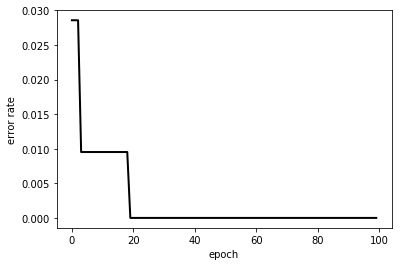

In [40]:
#plot out the decision line determined by learned weight and bias
import matplotlib.pyplot as plt
plot_x = range(100)
plot_y = accu_mat
plt.plot(plot_x, plot_y, color='k', linewidth=2)
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.show()

[-1.76349736  1.90518904]
[ 2.7281466  -5.15262881]


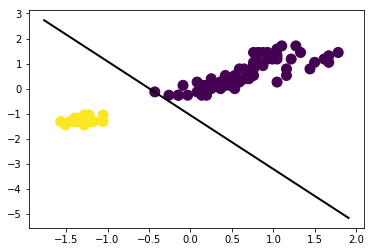

In [104]:
# plot boundary
Weight = np.squeeze(Weight)
bias = np.squeeze(bias)

x_train = x_train_1.to_numpy()
plot_x_b = np.array([np.min(x_train[:, 0] - 0.2), np.max(x_train[:, 1]+0.2)])
plot_y_b = 1 / Weight[1] * (-Weight[0] * plot_x_b - bias)
print(plot_x_b)
print(plot_y_b)
plt.scatter(x_train[:, 0], x_train[:, 1], c=np.squeeze(y_train_1), s=100, cmap='viridis')
plt.plot(plot_x_b, plot_y_b, color='k', linewidth=2)
plt.show()

<h1> Testing </h1>

In [80]:
import math
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [84]:
x_test = x_test_1.to_numpy()
y_hat = np.round(sigmoid(np.add(np.matmul(x_test.astype(np.float32),Weight),bias)))
#print(y_hat)
#print(y_test_1)

In [92]:
error = y_test_1 - y_hat
#print(np.count_nonzero(error))
accuracy = 1 - np.count_nonzero(error)/np.shape(error)[0]
print('Testing Accuracy is: ',accuracy)

Testing Accuracy is:  1.0


The testing accuracy is 1. From the boundry shown above, the petal and sepal of setosa are all negative and smaller than the other two species.

<h1>Part b: </h1>

In [105]:
x_2,y_2 = data_preprocessing(dataset,2,flower='Iris-virginica')
#generate traning and validation sets
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2,y_2,test_size=0.3)

Index(['petal_length', 'petal_width'], dtype='object')
species


In [107]:
print(x_train_2.shape)
print(y_train_2.shape)

(105, 2)
(105, 1)


<h2>Define hyper-parameter</h2>

In [129]:
#define number of training iterations
NUM_ITER = 100
#define learning rate
lr = 0.01

<h2>Define Placeholder and Variables</h2>

In [138]:
tf.reset_default_graph()
#define the placeholder to feed the training data later
X = tf.placeholder(tf.float32,shape=[105,2],name='X')
Y = tf.placeholder(tf.float32,shape=[105,1],name='Y')

#define the weights and initialized with random normal distribution
W = tf.Variable(tf.random_normal([2,1]),tf.float32,name='W')
#define the bias with zero initialization
b = tf.Variable(tf.zeros([1,1]),tf.float32,name='b')

<h2>Define update rule and accuracy</h2>

In [139]:
#define the predicted output label, Tensorflow doesn't have step function, we use tf.round to do that
Y_hat = tf.round(tf.sigmoid(tf.add(tf.matmul(X,W),b)))
#the error between target and logit
error = Y-Y_hat
accuracy = tf.count_nonzero(error,dtype=tf.dtypes.float32)/tf.size(error,out_type=tf.dtypes.float32)

#weight and bias update rule w(t+1) = w(t) + learning_rate * error * x
dW = tf.matmul(tf.transpose(X),error)
db = tf.reduce_sum(error,0)
W_ = W + lr*dW
b_ = b + lr*db

#group two operations together
step = tf.group(W.assign(W_), b.assign(b_))

<h2>Execute training</h2>

In [140]:
accu_mat = np.zeros([100])
#initialize tensorflow variables
init = tf.global_variables_initializer()

#start tensorflow session
with tf.Session() as sess:
    #run initialization
    sess.run(init)
    #training for number of iterations
    for i in range(NUM_ITER):
        #every iteration we run optimization on the training data X and labels Y
        sess.run(step,feed_dict = {X:x_train_2,Y:y_train_2})
        err_rate = sess.run(accuracy,feed_dict = {X:x_train_2,Y:y_train_2})
        accu_mat[i] = err_rate
        #print(err_rate)
    #after training, we acquire the weight and bias
    # np.squeeze plays a role to get rid of the redundant dimension [i.e.make (2,1) be (2,)]
    
    Weight = sess.run(W)
    bias = sess.run(b)
    

In [141]:
#print(accu_mat)
print('W:\n')
print(Weight)
print('b:\n')
print(bias)

W:

[[0.11260536]
 [0.7435485 ]]
b:

[[-0.45999974]]


<h2>Plot</h2>

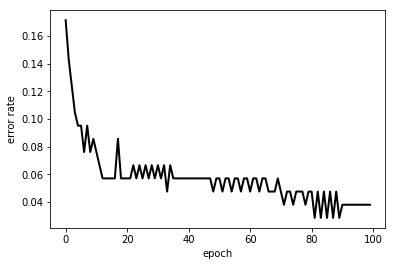

In [142]:
#plot out the decision line determined by learned weight and bias
import matplotlib.pyplot as plt
plot_x = range(100)
plot_y = accu_mat
plt.plot(plot_x, plot_y, color='k', linewidth=2)
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.show()

[-1.76349736  1.90518904]
[0.88572432 0.33012673]


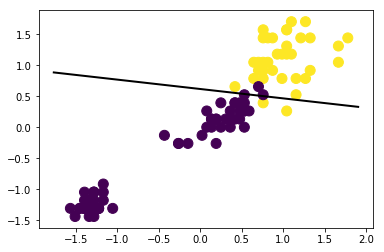

In [145]:
# plot boundary
Weight = np.squeeze(Weight)
bias = np.squeeze(bias)

x_train = x_train_2.to_numpy()
plot_x_b = np.array([np.min(x_train[:, 0] - 0.2), np.max(x_train[:, 1]+0.2)])
plot_y_b = 1 / Weight[1] * (-Weight[0] * plot_x_b - bias)
print(plot_x_b)
print(plot_y_b)
plt.scatter(x_train[:, 0], x_train[:, 1], c=np.squeeze(y_train_2), s=100, cmap='viridis')
plt.plot(plot_x_b, plot_y_b, color='k', linewidth=2)
plt.show()

<h1>Testing </h1>

In [143]:
import math
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [144]:
x_test = x_test_2.to_numpy()
y_hat = np.round(sigmoid(np.add(np.matmul(x_test.astype(np.float32),Weight),bias)))
#print(y_hat)
#print(y_test_1)
error = y_test_2 - y_hat
print(np.count_nonzero(error))
accuracy = 1 - np.count_nonzero(error)/np.shape(error)[0]
print('Testing Accuracy is: ',accuracy)

2
Testing Accuracy is:  0.9555555555555556


The testing accuracy is approximately 0.96. From the boundry shown above, the petal and sepal of virginica are all positive and higher than most of the non-virginica. However, it is a little hard to seperate them perfectly because some points cluster together.

<h1>Part c:</h1>

In [147]:
x_3,y_3 = data_preprocessing(dataset,4)
#generate traning and validation sets
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3,y_3,test_size=0.3)

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')
species


In [148]:
print(x_train_3.shape)
print(y_train_3.shape)

(105, 4)
(105, 3)


<h2>Define hyper-parameters</h2>

In [163]:
#learning rate
lr = 0.01
#number of traning steps
num_steps =200

#network parameters
n_hidden_1 = 256
n_hidden_2 = 128
num_input = 4
num_classes = 3

<h2>Define placehoder and variables</h2>

In [150]:
tf.reset_default_graph()

In [151]:
#tf graph input
X = tf.placeholder(tf.float32,[None,num_input],name='X')
Y = tf.placeholder(tf.int32,[None,num_classes],name='Y')

#Layers weight & bias
weights = {
    'W1': tf.Variable(tf.random_normal([num_input, n_hidden_1]),name='W1'),
    'W2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]),name='W2'),
    'Wout': tf.Variable(tf.random_normal([n_hidden_2, num_classes]),name='Wout')
}

biases = {
    'b1': tf.Variable(tf.zeros(shape=[n_hidden_1]),name='b1'),
    'b2': tf.Variable(tf.zeros(shape=[n_hidden_2]),name='b2'),
    'bout': tf.Variable(tf.zeros(shape=[num_classes]),name='bout')
}

<h2>Define the neural network</h2>

In [152]:
#define a neural net model
def neural_net(x):
    layer_1_out = tf.nn.relu(tf.add(tf.matmul(x,weights['W1']),biases['b1']))
    layer_2_out = tf.nn.relu(tf.add(tf.matmul(layer_1_out,weights['W2']),biases['b2']))
    out = tf.add(tf.matmul(layer_2_out,weights['Wout']),biases['bout'])
    return out

<h2>Define cost function and accuracy</h2>

In [153]:
#predicted labels
pred = neural_net(X)

#define loss
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred,labels=Y),name='loss')
#define optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(pred,1),tf.argmax(Y,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

#Initialize the variables
init = tf.global_variables_initializer()

<h2>Execute training</h2>

In [166]:
accu_mat = np.zeros([200])
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(num_steps):
        #run optimization
        sess.run(train_op, feed_dict={X:x_train_3, Y:y_train_3})
        acc = sess.run(accuracy,feed_dict={X:x_train_3, Y:y_train_3})
        accu_mat[i] = acc
        if i % 100 ==0:
            print("step "+str(i)+", Accuracy= {:.3f}".format(acc))
    
    print("Training finished!")
    
    print("Testing ACcuracy:", sess.run(accuracy, feed_dict={X:x_test_3, Y:y_test_3}))

step 0, Accuracy= 0.695
step 100, Accuracy= 0.990
Training finished!
Testing ACcuracy: 0.9111111


<h2>Plot</h2>

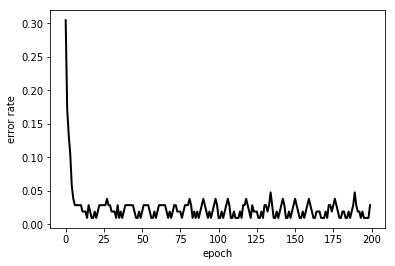

In [167]:
#plot out the decision line determined by learned weight and bias
import matplotlib.pyplot as plt
plot_x = range(200)
plot_y = 1-accu_mat
plt.plot(plot_x, plot_y, color='k', linewidth=2)
plt.xlabel('epoch')
plt.ylabel('error rate')
plt.show()